In [1]:
import numpy as np
from plnn import PLNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import utilities as utils
import matplotlib.pyplot as plt

/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:

# ==================================
# Generate Training Points
# ==================================
print('===============Generating Training Points============')
# random points at least 2r apart
m = 12
# np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

layer_sizes = [2,50,50,50,2]


===============Generating Training Points============


In [3]:
unique_polytopes = []
unique_polytopes_reg = []

errs = []
errs_reg = []

reg_coeffs = [elem for elem in np.linspace(1e-5, 1, 4)]

for l1_scale in reg_coeffs:
    
    # ==================================
    # Initialize Network
    # ==================================

    print('===============Initializing Network============')
    network = PLNN(layer_sizes)
    net = network.net

    # ==================================
    # Train Network
    # ==================================

    print('===============Training Network============')
    opt = optim.Adam(net.parameters(), lr=1e-3)
    for i in range(1000):
        out = net(Variable(X))
        l = nn.CrossEntropyLoss()(out, Variable(y))
        err = (out.max(1)[1].data != y).float().mean()
        opt.zero_grad()
        (l).backward()
        opt.step()

    print('error: ', err)
    errs.append(err)
    
    # ==================================
    # Gather Polytopes
    # ==================================
    print('===============Gathering Polytopes============')
    num_pts = 200
    xylim = 1.0

    unique_relu_configs_list, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
    print('number of polytopes:', len(unique_bin_acts))
    unique_polytopes.append(len(unique_bin_acts))
    
    #--------------------------------------------------------------------------------------------

    # ==================================
    # Initialize Network
    # ==================================

    print('===============Initializing Network============')
    network = PLNN(layer_sizes)
    net = network.net

    # ==================================
    # Train Network
    # ==================================

    print('===============Training Network with Regularization============')
    opt = optim.Adam(net.parameters(), lr=1e-3)
    for i in range(1000):
        out = net(Variable(X))
        l = nn.CrossEntropyLoss()(out, Variable(y))

        l1_scale = 1 * 1e-3
        l1_loss = lambda : l1_scale * sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])

        l += l1_loss()
        err = (out.max(1)[1].data != y).float().mean()
        opt.zero_grad()
        (l).backward()
        opt.step()

    print('error: ', err)
    errs_reg.append(err)

    # ==================================
    # Gather Polytopes
    # ==================================
    print('===============Gathering Polytopes============')
    num_pts = 200
    xylim = 1.0

    unique_relu_configs_list, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
    print('number of polytopes:', len(unique_bin_acts))
    unique_polytopes_reg.append(len(unique_bin_acts))
    


===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=50, bias=True)
  (6): ReLU()
  (7): Linear(in_features=50, out_features=2, bias=True)
)
===============Training Network============
error:  tensor(0.)
===============Gathering Polytopes============
number of polytopes: 772
===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=50, bias=True)
  (6): ReLU()
  (7): Linear(in_features=50, out_features=2, bias=True)
)
===============Training Network with Regularization============
error:  tensor(0.)
===============Gathering Polytopes============
number of polytopes: 219
===============Initializing Network=======

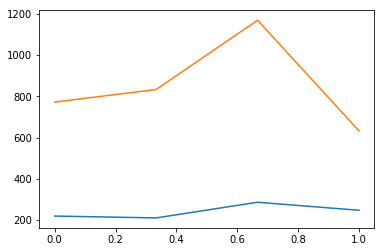

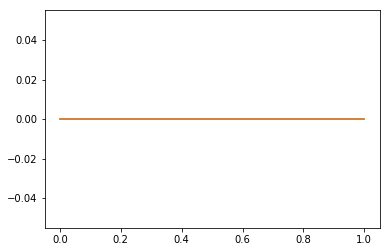

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(reg_coeffs,unique_polytopes_reg)
plt.plot(reg_coeffs,unique_polytopes)
plt.show()

plt.figure()
plt.plot(reg_coeffs,errs_reg)
plt.plot(reg_coeffs,errs)
plt.show()

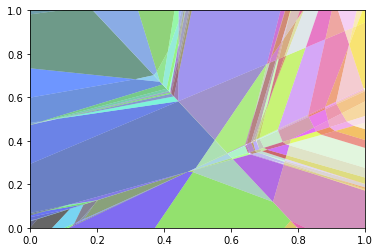

In [7]:
# ------------------------------
# Plot Polytopes
# ------------------------------
from _polytope_ import Polytope, from_polytope_dict

polytope_list = []


for relu_configs, unique_act in zip(unique_relu_configs_list, unique_bin_acts):
    polytope_dict = network.compute_polytope_config(relu_configs, True)
    polytope = from_polytope_dict(polytope_dict)
    polytope_list.append(polytope)

ax = plt.gca()
alpha = 0.6
xylim = 1.0

colors = utils.get_spaced_colors(len(polytope_list))
utils.plot_polytopes_2d(polytope_list, colors, alpha, xylim, ax)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()